# pki_nn_models.ipynb
The purpose of this file is to a neural network model based on the pki dataset. Since the pki dataset is imbalanced, upsampling will be performed frist followed by the model training 

## Upsampling the data

d_X shape:  (292422, 26)
d_y shape:  (292422, 1)

X_train shape:  (204695, 26)
X_test shape:  (87727, 26)
y_train shape:  (204695, 1)
y_test shape:  (87727, 1)


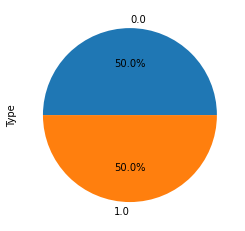

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

pki_df = pd.read_csv("../MLP2/input/heart_2020_normalized.csv")
x_columns = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']
y_columns = ['HeartDisease']
target_names = ['No Heart Disease', 'Has Heart Disease']

positive_df = pki_df[pki_df['HeartDisease'] == 1]
negative_df = pki_df[pki_df['HeartDisease'] == 0]

tmp = resample(negative_df, replace=True, n_samples=int(len(negative_df) / 2), random_state=42)
upsample = resample(positive_df, replace=True, n_samples=len(tmp), random_state=42)
upsampled_df = pd.concat([tmp, upsample])
upsampled_df.groupby('HeartDisease').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

u_X = np.c_[upsampled_df[x_columns]]
u_y = np.c_[upsampled_df[y_columns]]

print("d_X shape: ", u_X.shape)
print("d_y shape: ", u_y.shape)

uX_train, uX_test, uy_train, uy_test = train_test_split(u_X, u_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", uX_train.shape)
print("X_test shape: ", uX_test.shape)
print("y_train shape: ", uy_train.shape)
print("y_test shape: ", uy_test.shape)

## Training the MLP Classifier

In [4]:
from dataclasses import dataclass

@dataclass
class MetricContainer:
    name: str
    precision: float = 0
    recall: float = 0
    f1_score: float = 0

def average_classification_report(arr: list):
    no_hd = MetricContainer('No Heart Disease')
    has_hd = MetricContainer('Has Heart Disease')

    for elem in arr:
        no_hd.precision += elem['No Heart Disease']['precision']
        no_hd.recall += elem['No Heart Disease']['recall']
        no_hd.f1_score += elem['No Heart Disease']['f1-score']

        has_hd.precision += elem['Has Heart Disease']['precision']
        has_hd.recall += elem['Has Heart Disease']['recall']
        has_hd.f1_score += elem['Has Heart Disease']['f1-score']   

    size = len(arr)
    no_hd.precision /= size
    no_hd.recall /= size
    no_hd.f1_score /= size

    has_hd.precision /= size
    has_hd.recall /= size
    has_hd.f1_score /= size

    print(no_hd)
    print(has_hd)

    return has_hd.recall
    
def find_optimal_value(values: list, report: list) -> int:
    optimal_value = values[0]
    recall = report[0]

    for idx, val in enumerate(values[0:]):
        if (report[idx] > recall):
            optimal_value = val
            recall = report[idx]
    return optimal_value

In [3]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=None, shuffle=True)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [100, 500, 1000]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=iter, random_state=42)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.7998147978226118, recall=0.7259069444933106, f1_score=0.7608994678309596)
MetricContainer(name='Has Heart Disease', precision=0.7483131897476368, recall=0.8172884248752776, f1_score=0.7811501636224751)
